Kilosort sort and display

runs some everything through kilosort, then do some plotting of the results

In [1]:
import numpy as np
import pandas as pd
from kilosort import run_kilosort, io
from matplotlib import pyplot as plt
from matplotlib import rcParams, gridspec
from os import sep, path

from tkinter import Tk
from tkinter import filedialog

from spikeinterface.extractors import read_openephys
from openephys_utils import open_sig_events, save_filt_signal

# %matplotlib qt

Choose the probe and the data directory

In [2]:
# open a file dialog for the probe
if 'probe_fd' not in locals():
    root = Tk()
    probe_fd = filedialog.askopenfilename(master=root)
    root.withdraw()

    # FD for the recording folder
    dd = filedialog.askdirectory(master=root, initialdir=probe_fd.split(sep))


Load the probe, convert the openephys to binary

In [3]:

# load a probe
probe = io.load_probe(probe_fd)

# read the openephys
oeps = read_openephys(dd)

# load it and convert it into binary
filename, N, c, s, fs, _ = io.spikeinterface_to_binary(
    oeps, dd, data_name = 'recording.bin', dtype = np.int16,
    chunksize=60000
)


run kilosort

In [4]:

# put together some settings
# 64 channels, save the cleaned data to compare
# no drift correction (apparantly the electrodes are too sparse)
# 
settings = {'filename':filename, 'probe_path':probe_fd, 'n_chan_bin': 72, #'nblocks':0,
            'save_preprocessed_blocks': True}


# # 
results = run_kilosort(settings=settings)

kilosort.run_kilosort: Kilosort version 4.0.17
kilosort.run_kilosort: Sorting \\striatum\shared\BrainPatch\20241002\Crimson__2024-10-02_12-00-49__spontaneous_waking\recording.bin
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 12669984
kilosort.run_kilosort: N seconds: 422.3328
kilosort.run_kilosort: N batches: 212
kilosort.run_kilosort: Preprocessing filters computed in  1.45s; total  1.46s
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.spikedetect: Re-computing univ

Load all of the saved files for plotting purposes

In [5]:
# outputs saved to results_dir
results_dir = path.join(dd, 'kilosort4')
ops = io.load_ops(path.join(results_dir, 'ops.npy'))

# cluster amplitudes
camps = pd.read_csv(path.join(results_dir, 'cluster_Amplitude.tsv'), sep='\t')['Amplitude'].values

# contamination percentage for each cluster
contam_pct = pd.read_csv(path.join(results_dir, 'cluster_ContamPct.tsv'), sep='\t')['ContamPct'].values

# channel map -- this will be helpful
chan_map =  np.load(path.join(results_dir , 'channel_map.npy'))

# template for each unit. worth taking a look at
templates =  np.load(path.join(results_dir , 'templates.npy'))

# the "best" spike per channel -- spike with the largest amplitude, for each channel
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]

# amplitudes, spike times, and clusters
amplitudes = np.load(path.join(results_dir , 'amplitudes.npy'))
st = np.load(path.join(results_dir , 'spike_times.npy'))
clu = np.load(path.join(results_dir , 'spike_clusters.npy'))

# average firing rates
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()

# load in the raw and filtered signal
save_filt_signal(dd)
sig = np.load(path.join(dd, 'filt_sig.npy'))
ts = np.load(path.join(dd, 'timestamps.npy'))


Show the plots -- first with just the method from the kilosort

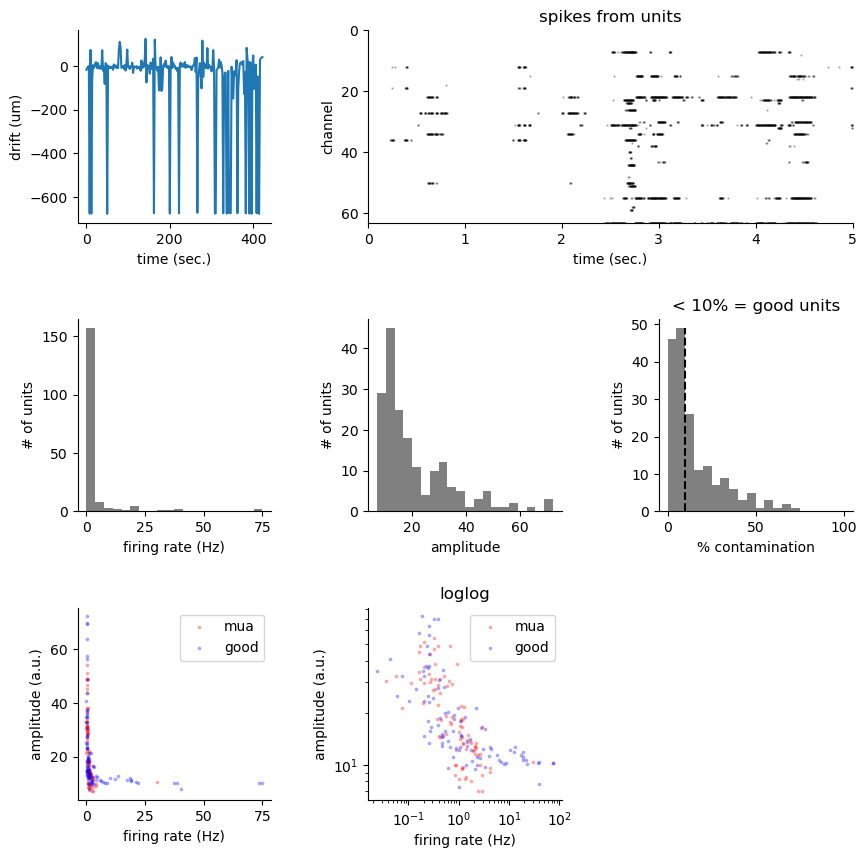

In [7]:
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5*np.ones(3)

# set up a big canvas to work with
fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

# first plot -- drift over time as defined by kilosort
dshift = ops['dshift']
ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift)
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

# highest magnitude spike per channel for the first 5 seconds
ax = fig.add_subplot(grid[0,1:])
t0 = 0 
t1 = np.nonzero(st > ops['fs']*5)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

Look at the units vs the filtered recordings

In [22]:
# probe = ops['probe']
# # x and y position of probe sites
# xc, yc = probe['xc'], probe['yc']
good_units = np.nonzero(contam_pct <= 0.1)[0]
big_units = np.nonzero(camps > 20)[0]

# # pull out the templates for the "good" units
# good_temps = templates[good_units]
# cb = chan_best[good_units]


# pick channels to show
channels = [32, 36, 39, 42, 48, 51]
chan_mask = [chan in channels for chan in chan_best]


In [26]:
fig,ax = plt.subplots()

for i_template in range(65):
    ax.plot(good_temps[i_template, :, cb[i_template]])


In [ ]:

# create a figure, trying it with gridspec instead of the automatic layout
fig_comp, ax_comp = plt.subplots(nrow = len(channels), sharex = True, gridspec_kw={'hspace':0.5})
# fig_comp = plt.figure()
# grid = gridspec.GridSpec(nrows = len(channels), figure = fig_comp, hspace = 0.5)

bin,edges = np.histogram(st, bins=20)
max_bin = np.argmax(bin)
inds = [int(edges[max_bin]),int(edges[max_bin+1])]
for i_channel, channel in enumerate(channels):
    ax_comp[i_channel].plot(ts[inds[0]:inds[1]], sig[inds[0]:inds[1], channel])
    ax_comp[i_channel].
    




In [19]:
# np.histogram(st, bins = 20)

bin,edges = np.histogram(st, bins=20)
max_bin = np.argmax(bin)

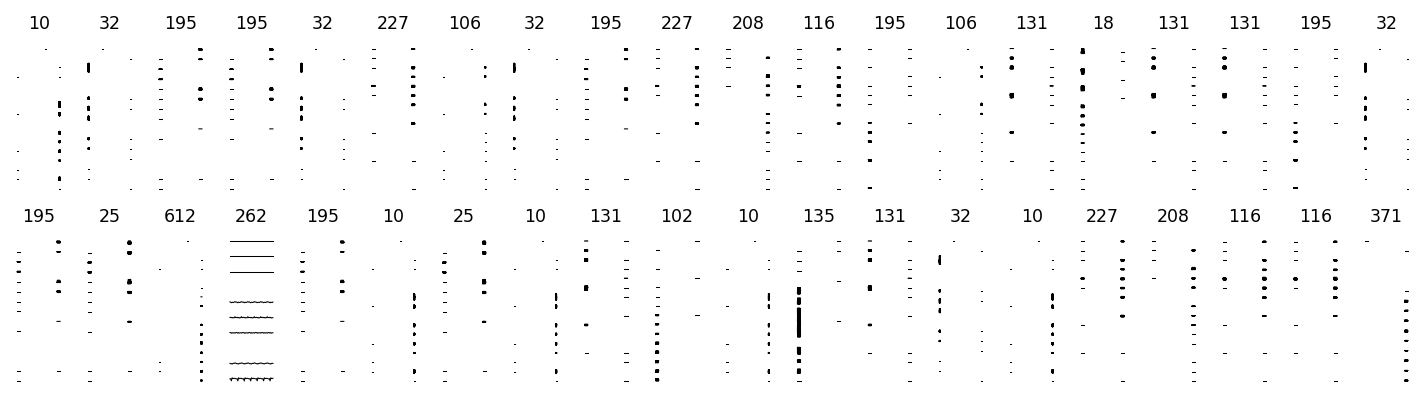

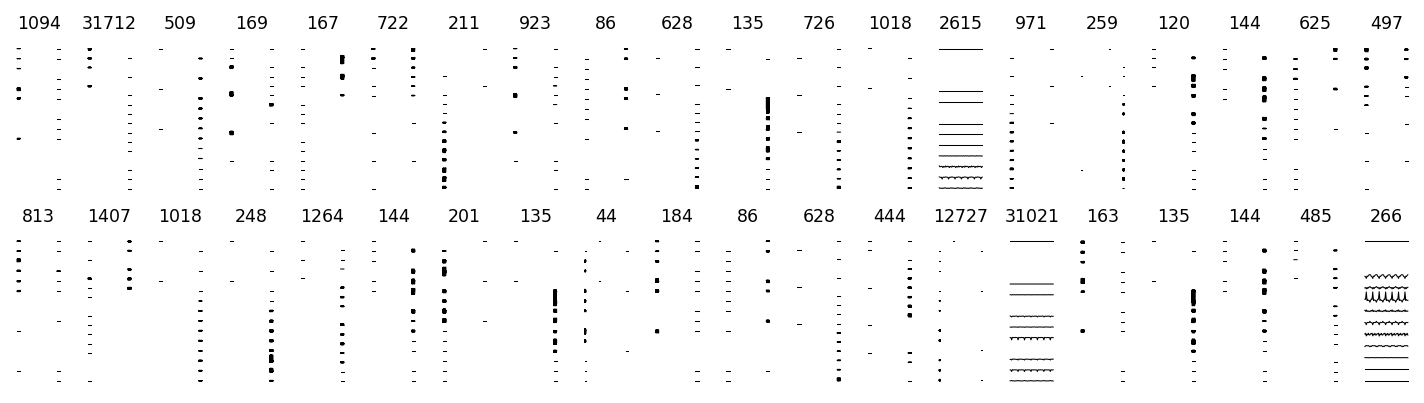

In [9]:
probe = ops['probe']
# x and y position of probe sites
xc, yc = probe['xc'], probe['yc']
nc = 16 # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]


gstr = ['good', 'mua']
# gstr = ['good']
for j,g in enumerate(gstr):
    units = good_units if j==0 else mua_units 
    fig = plt.figure(figsize=(12,3), dpi=150)
    grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(40):
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()  
        cb = chan_best[wi]
        nsp = (clu==wi).sum()
        
        ax = fig.add_subplot(grid[k//20, k%20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb-nc//2)
        ic1 = min(n_chan, cb+nc//2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi,yi) in enumerate(zip(x0,y0)):
            t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    plt.show()